In [73]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, deque
from cdlib.classes import NodeClustering

def draw_graph(G: nx.Graph, **kwargs):
    plt.title(G.name)
    nx.draw(G, with_labels=True, **kwargs)
    plt.show()

def read_with_clusters(path):
	G = nx.Graph()
	with open(path, 'r') as file:
		line = file.readline()
		n = int(line.strip().split(" ")[1])
		for i in range(n):
			parts = file.readline().strip().split(" ")
			id = int(parts[0])
			label = parts[1]
			cluster_id = int(parts[2])
			G.add_node(id, label=label, cluster=cluster_id)
		line = file.readline()
		m = int(line.strip().split(" ")[1])
		for _ in range(m):
			parts = file.readline().strip().split(" ")
			G.add_edge(int(parts[0]), int(parts[1]))
			
	return G

def distance(G, i):
	D = [-1] * len(G) # D = {}
	Q = deque()
	D[i] = 0
	Q.append(i)
	while Q:
		i = Q.popleft()
		for j in G[i]:
			if D[j] == -1: # if j not in D:
				D[j] = D[i] + 1
				Q.append(j)
	return [d for d in D if d > 0]

def distances(G, n = 100):
	D = []
	approx = G.nodes()
	if len(G) > n:
		approx = random.sample(list(G.nodes()), n)
	for i in approx:
		D.append(distance(G, i))
	return D

def lcc(G: nx.Graph) -> float:
    """relative size of the largest connected component (between 0 and 1)"""
    if G.is_directed(): G = nx.Graph(G)

    return len(max(nx.connected_components(G), key=len)) / len(G)

def distribution(G):
	degrees = np.array(sorted([G.degree(n) for n in G.nodes()], reverse=True))
	count_general = Counter(degrees)
	fig = plt.figure()
	plt.xscale("log")
	plt.yscale("log")
	general_dist = plt.scatter(count_general.keys(), count_general.values(), label="General degrees", s=20)
	plt.xlabel("k")
	plt.ylabel("p(k)")
	plt.legend()
	plt.title(G.name)
	plt.show()
	plt.savefig(f"{G.name}")

def info(G):
	print("{:>20s} | '{:s}'".format('Graph', G.name))
	n = G.number_of_nodes()
	print("{:>20s} | {:,d}".format('Nodes', n))
	m = G.number_of_edges()
	print("{:>20s} | {:,d}".format('Edges', m))
	k = 2*m/n
	print("{:>20s} | {:.2f}".format('Degree', k))
	max_degree = max([G.degree(n) for n in G.nodes()])
	print("{:>20s} | {:.2f}".format('Max node degree', max_degree))
	cc = lcc(G)
	print("{:>20s} | {:.2f}".format('LCC', cc))
	dis = [i for d in distances(G) for i in d]
	print("{:>20s} | {:.2f} ({:,d})".format('Distance', sum(dis) / len(dis), max(dis)))
	density = k/(n-1)
	print("{:>20s} | {:.9f}".format('Density', density))
	clustering = nx.average_clustering(G)
	print("{:>20s} | {:.9f}".format('Clustering', clustering))
	distribution(G)

def top_nodes(G: nx.Graph, C: dict[any, float], centrality: str, n=15) -> dict[any]:
    """prints and returns top n nodes by given measure of centrality"""

    # OPT take callable instead of dict, only compute centrality on non-mode nodes
    # OPT np.argpartition instead of sort
    print("{:>12s} | '{:s}'".format('Centrality', centrality))
    nodes = []
    for i, c in sorted(C.items(), key=lambda item: (item[1], G.degree[item[0]]), reverse=True):
        if not G.nodes[i]['label'].startswith('m-'):
            nodes.append(G.nodes[i])
            print("{:>12.6f} | '{:s}' ({:,d})".format(
                c, G.nodes[i]['label'], G.degree[i]))
            n -= 1
            if n == 0:
                break
    print()
    return nodes
def actor_names(nodes) -> list[str]:
    """Parses labels of nodes in collaboration_imdb.net into
    a nicer format. Try pasting the ouput of this function into
    chatGPT if you have trouble classifying the actors."""
    names = []
    for n in nodes:
        try:
            last, fst = n["label"].split(", ")
            if fst[-1] == ')':
                fst = fst[:fst.index('(') - 1]

            names.append(f"{fst} {last}")
        except ValueError: # failed unpacking
            names.append(n["label"])

    return names
def random_walk(G):
	n = G.number_of_nodes()
	visited = set([])
	current = random.sample(list(G.nodes()), 1)[0]
	while len(visited)/n < 0.15:
		visited.add(current)
		current = random.sample(list(G[current]), 1)[0]
	
	return nx.convert_node_labels_to_integers(nx.Graph(nx.induced_subgraph(G, visited)))

def eigenvector_centrality(G, eps = 1e-6):
    # Initialize eigenvector centrality score
    E = [1] * G.number_of_nodes()
    diff = 1
    # Repeat until the change in scores is less than a small value 'eps'
    while diff > eps:
        # Update scores based on neighbors' scores
        U = [sum([E[j] for j in G[i]]) for i in G.nodes()]
        # Normalize scores
        u = sum(U)
        U = [U[i] * len(G) / u for i in G.nodes()]
        # Calculate change in scores
        diff = sum([abs(E[i] - U[i]) for i in G.nodes()])
        # Use the new scores for the next iteration
        E = U
    return {i: E[i] for i in range(len(E))}

In [68]:
# Prva naloga
G = nx.convert_node_labels_to_integers(read_with_clusters("dolphins.net"), label_attribute=None)
#degree_centrality = top_nodes(G, nx.degree_centrality(G), 'centrality')
#clustering = top_nodes(G, nx.clustering(G), 'clustering')

#mi_corrected_clustering = {i: c * (G.degree(i) - 1) for i, c in nx.clustering(G).items()}
#mi_corrected(G, mi_corrected_clustering, 'mi corrected clustering')
#pagerank_cent = top_nodes(G, nx.pagerank(G), 'pagerank')
#closeness_cent = top_nodes(G, nx.closeness_centrality(G), 'closeness')
betweenness_cent = top_nodes(G, nx.betweenness_centrality(G), 'betweenness')

  Centrality | 'betweenness'
    0.248237 | '"SN100"' (7)
    0.213324 | '"Beescratch"' (8)
    0.143150 | '"SN9"' (8)
    0.138570 | '"SN4"' (11)
    0.118239 | '"DN63"' (5)
    0.114300 | '"Jet"' (9)
    0.102646 | '"Kringel"' (9)
    0.099122 | '"Upbang"' (7)
    0.084677 | '"Trigger"' (10)
    0.084205 | '"Web"' (9)
    0.070517 | '"SN89"' (2)
    0.066757 | '"Oscar"' (5)
    0.065529 | '"Patchback"' (9)
    0.062831 | '"Stripes"' (7)
    0.061972 | '"Grin"' (12)



               Graph | 'social'
               Nodes | 10,680
               Edges | 24,316
              Degree | 4.55
     Max node degree | 205.00
                 LCC | 1.00
            Distance | 7.68 (24)
             Density | 0.000426403
          Clustering | 0.265945224


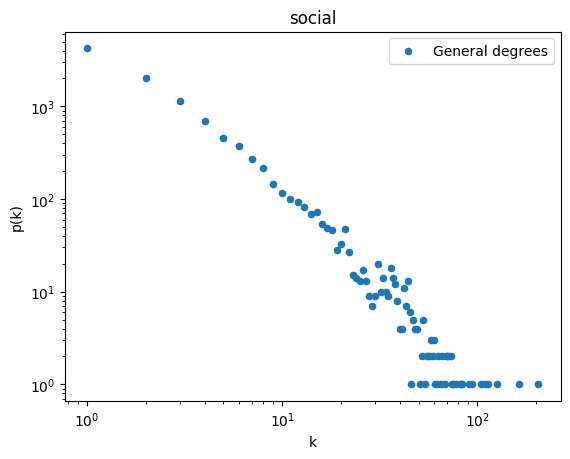


               Graph | 'social'
               Nodes | 1,602
               Edges | 6,860
              Degree | 8.56
     Max node degree | 166.00
                 LCC | 1.00
            Distance | 5.72 (18)
             Density | 0.005349341
          Clustering | 0.407641848


<Figure size 640x480 with 0 Axes>

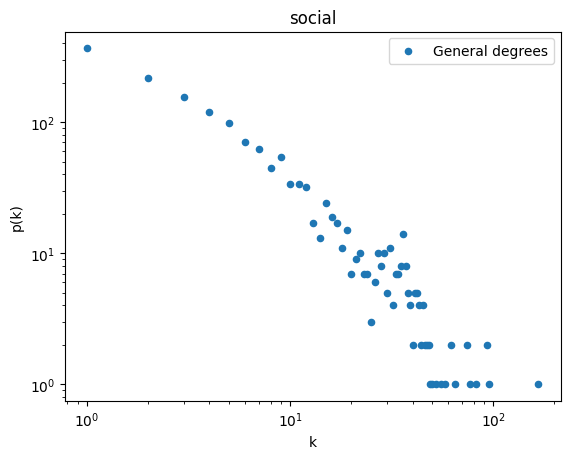

<Figure size 640x480 with 0 Axes>

In [74]:
network =  'social'
file = f"{network}.net"
G = nx.Graph(nx.convert_node_labels_to_integers(nx.read_pajek(file)))
G.name = network
info(G)
print()
SG = nx.Graph(random_walk(G))
info(SG)

[4, 6, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 55, 56, 57, 60, 63, 67, 74, 79, 80, 101, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 136, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 179, 183, 184, 185, 188, 189, 194, 195, 197, 199, 200, 201, 202, 203, 208, 209, 211, 212, 215, 216, 217, 218, 219, 220, 223, 225, 226, 227, 228, 229, 235, 237, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 250, 252, 253, 260, 261, 262, 273, 277, 279, 283, 286, 291, 300, 306, 307, 316, 317, 325, 326, 346, 350, 364, 369, 380, 381, 382, 384, 386, 387, 388, 389, 390, 391, 392, 393, 394, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 409, 410, 411, 413, 414, 416, 